In [1]:
from __future__ import print_function

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.utils.data_utils import get_file
from keras.callbacks import ModelCheckpoint

import numpy as np
import random
import sys
import os
import re
import codecs
import collections

Using TensorFlow backend.


In [2]:
# gpu device check
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17625276767741418560
]


In [3]:
def prepare_unique_words(text_string):
    words_regex = r"\W+"
    punctuation_regex = r"[^\w]"

    punctuations = set(re.findall(punctuation_regex, text_string))
    words = set(re.sub(words_regex, " ", text_string).split())

    words_set = words.union(punctuations)
    return words_set

def process_text(text_string):
    words_regex = r"\W+"
    punctuation_regex = r"[^\w]"

    punctuations = re.findall(punctuation_regex, text_string)
    words = re.sub(words_regex, " ", text_string).split()

    words_set = words.union(punctuations)
    return words_set

In [46]:
input_file = "../datasets/i_malavoglia_short.txt"
saves_folder = "saves/"
encoding=None

with codecs.open(input_file, "r", encoding=encoding) as f:
    text = f.read()
    
print('corpus length:', len(text))

corpus length: 18012


In [6]:
#try: 
#    text = open(path).read().lower()
#except UnicodeDecodeError:
#    import codecs
#    text = codecs.open(path, encoding='utf-8').read().lower()

#print('corpus length:', len(text))

In [20]:
text =  "O Marcio <COMMA>  <EOL> sono io <COMMA>  ricordi <QUESTION>  <EOL>  <EOL> Quel che t <APOSTR> avea marcito <EOL> Un tempo lontano <DOT>  Ahimé <EXCLAM> Non son uomo ma bestia ormai <DOT> "

In [47]:
processed = re.sub("\n", ' <EOL> ', text)
processed = re.sub("[,]", ' <COMMA> ', processed)
processed = re.sub("[.]", ' <DOT> ', processed)
processed = re.sub("[']", ' <APOSTR> ', processed)
processed = re.sub("[!]", ' <EXCLAM> ', processed)
processed = re.sub("[?]", ' <QUESTION> ', processed)
processed = re.sub("[;]", ' <SEMICOL> ', processed)

In [48]:
print(processed)

 <EOL> Un tempo i Malavoglia erano stati numerosi come i sassi della strada vecchia di Trezza <SEMICOL>  ce n’erano persino ad Ognina <COMMA>  e ad Aci Castello <COMMA>  tutti buona e brava gente di mare <COMMA>  proprio all’opposto di quel che sembrava dal nomignolo <COMMA>  come dev’essere <DOT>  Veramente nel libro della parrocchia si chiamavano Toscano <COMMA>  ma questo non voleva dir nulla <COMMA>  poichè da che il mondo era mondo <COMMA>  all’Ognina <COMMA>  a Trezza e ad Aci Castello <COMMA>  li avevano sempre conosciuti per Malavoglia <COMMA>  di padre in figlio <COMMA>  che avevano sempre avuto delle barche sull’acqua <COMMA>  e delle tegole al sole <DOT>  Adesso a Trezza non rimanevano che i Malavoglia di padron ’Ntoni <COMMA>  quelli della casa del nespolo <COMMA>  e della Provvidenza ch’era ammarrata sul greto <COMMA>  sotto il lavatoio <COMMA>  accanto alla Concetta dello zio Cola <COMMA>  e alla paranza di padron Fortunato Cipolla <DOT>  <EOL>  <EOL> Le burrasche che ave

In [49]:
words = processed.split()
words

['<EOL>',
 'Un',
 'tempo',
 'i',
 'Malavoglia',
 'erano',
 'stati',
 'numerosi',
 'come',
 'i',
 'sassi',
 'della',
 'strada',
 'vecchia',
 'di',
 'Trezza',
 '<SEMICOL>',
 'ce',
 'n’erano',
 'persino',
 'ad',
 'Ognina',
 '<COMMA>',
 'e',
 'ad',
 'Aci',
 'Castello',
 '<COMMA>',
 'tutti',
 'buona',
 'e',
 'brava',
 'gente',
 'di',
 'mare',
 '<COMMA>',
 'proprio',
 'all’opposto',
 'di',
 'quel',
 'che',
 'sembrava',
 'dal',
 'nomignolo',
 '<COMMA>',
 'come',
 'dev’essere',
 '<DOT>',
 'Veramente',
 'nel',
 'libro',
 'della',
 'parrocchia',
 'si',
 'chiamavano',
 'Toscano',
 '<COMMA>',
 'ma',
 'questo',
 'non',
 'voleva',
 'dir',
 'nulla',
 '<COMMA>',
 'poichè',
 'da',
 'che',
 'il',
 'mondo',
 'era',
 'mondo',
 '<COMMA>',
 'all’Ognina',
 '<COMMA>',
 'a',
 'Trezza',
 'e',
 'ad',
 'Aci',
 'Castello',
 '<COMMA>',
 'li',
 'avevano',
 'sempre',
 'conosciuti',
 'per',
 'Malavoglia',
 '<COMMA>',
 'di',
 'padre',
 'in',
 'figlio',
 '<COMMA>',
 'che',
 'avevano',
 'sempre',
 'avuto',
 'delle',
 'ba

In [24]:
def build_vocab(words):
    word_counts = collections.Counter(words)
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    vocabulary_inv = list(sorted(vocabulary_inv))
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return vocabulary, vocabulary_inv

In [25]:
vocab, vocab_inv = build_vocab(words)
vocab

{'<APOSTR>': 0,
 '<COMMA>': 1,
 '<DOT>': 2,
 '<EOL>': 3,
 '<EXCLAM>': 4,
 '<QUESTION>': 5,
 'Ahimé': 6,
 'Marcio': 7,
 'Non': 8,
 'O': 9,
 'Quel': 10,
 'Un': 11,
 'avea': 12,
 'bestia': 13,
 'che': 14,
 'io': 15,
 'lontano': 16,
 'ma': 17,
 'marcito': 18,
 'ormai': 19,
 'ricordi': 20,
 'son': 21,
 'sono': 22,
 't': 23,
 'tempo': 24,
 'uomo': 25}

In [26]:
tensor = np.array(list(map(vocab.get, words)))
tensor

array([ 9,  7,  1,  3, 22, 15,  1, 20,  5,  3,  3, 10, 14, 23,  0, 12, 18,
        3, 11, 24, 16,  2,  6,  4,  8, 21, 25, 17, 13, 19,  2])

In [50]:
chars_set = set(processed)
words_set = set(processed.split())
#words = set(open(path).read().lower().split())

print("chars:",type(chars_set))
print("words",type(words_set))
print("total number of unique words",len(words_set))
print("total number of unique chars", len(chars_set))


word_indices = dict((c, i) for i, c in enumerate(words_set))
indices_word = dict((i, c) for i, c in enumerate(words_set))

print("word_indices", type(word_indices), "length:",len(word_indices) )
print("indices_words", type(indices_word), "length", len(indices_word))

chars: <class 'set'>
words <class 'set'>
total number of unique words 1199
total number of unique chars 64
word_indices <class 'dict'> length: 1199
indices_words <class 'dict'> length 1199


In [53]:
maxlen = 30
step = 3
print("maxlen:",maxlen,"step:", step)
sentences = []
next_words = []
next_words= []
sentences1 = []
list_words = []

sentences2=[]
#list_words=text.lower().split()
list_words = processed.split()

for i in range(0,len(list_words)-maxlen, step):
    sentences2 = ' '.join(list_words[i: i + maxlen])
    #print(sentences2)
    sentences.append(sentences2)
    next_words.append((list_words[i + maxlen]))
print('nb sequences(length of sentences):', len(sentences))
print("length of next_word",len(next_words))

maxlen: 30 step: 3
nb sequences(length of sentences): 1173
length of next_word 1173


In [54]:
len(words_set)

1199

In [55]:
maxlen

30

In [56]:
print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(words_set)), dtype=np.bool)
y = np.zeros((len(sentences), len(words_set)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, word in enumerate(sentence.split()):
        #print(i,t,word)
        X[i, t, word_indices[word]] = 1
    y[i, word_indices[next_words[i]]] = 1

Vectorization...


In [58]:
X.shape

(1173, 30, 1199)

In [57]:
X.shape[2]

1199

In [64]:
True in X[0,1]

True

In [34]:
#build the model: 2 stacked LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(maxlen, len(words_set))))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(len(words_set)))
#model.add(Dense(1000))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

Build model...


In [25]:
weight_file = saves_folder + 'weights.hdf5'

#if os.path.isfile(weight_file):
#    model.load_weights(weight_file)

In [39]:
y

array([[False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False]], dtype=bool)

In [42]:
X[0,1]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False], dtype=bool)

In [26]:
# train the model

checkpoint_filepath = "saves/weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history = model.fit(X, y, batch_size=128, nb_epoch=20, callbacks=callbacks_list)
#model.save_weights(weight_file, overwrite=True)

/home/scientist/app/miniconda3/envs/marciuscience/lib/python3.6/site-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/20
11597/11597 [==============================] - 37s 3ms/step - loss: 6.3618

Epoch 00001: loss improved from inf to 6.36176, saving model to saves/weights-improvement-01-6.36.hdf5
Epoch 2/20
11597/11597 [==============================] - 36s 3ms/step - loss: 5.9987

Epoch 00002: loss improved from 6.36176 to 5.99866, saving model to saves/weights-improvement-02-6.00.hdf5
Epoch 3/20
11597/11597 [==============================] - 36s 3ms/step - loss: 5.9350

Epoch 00003: loss improved from 5.99866 to 5.93496, saving model to saves/weights-improvement-03-5.93.hdf5
Epoch 4/20
11597/11597 [==============================] - 36s 3ms/step - loss: 5.8479

Epoch 00004: loss improved from 5.93496 to 5.84793, saving model to saves/weights-improvement-04-5.85.hdf5
Epoch 5/20
11597/11597 [==============================] - 36s 3ms/step - loss: 5.7796

Epoch 00005: loss improved from 5.84793 to 5.77957, saving model to saves/weights-improvement-05-5.78.hdf5
Epoch 6/20
11597/11597 [==========

In [28]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 30, 512)           12912640  
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 512)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5792)              2971296   
_________________________________________________________________
activation_2 (Activation)    (None, 5792)              0         
Total params: 17,983,136
Trainable params: 17,983,136
Non-trainable params: 0
________________________________________________________________

In [16]:
#model.load_weights("saves/weights-improvement-20-4.73.hdf5")

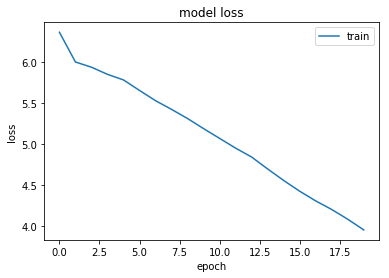

In [29]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [30]:
# train the model, output generated text after each iteration
#for iteration in range(1, 300):
#    print()
#    print('-' * 50)
#    print('Iteration', iteration)
#    history = model.fit(X, y, batch_size=128, nb_epoch=2)
#    model.save_weights(weight_file, overwrite=True)

### Sampling

In [31]:
# sample 20 experiment of rolling a dice, repeat for 10 times
np.random.multinomial(20, [1./6]*6, 10)

array([[2, 3, 2, 3, 6, 4],
       [2, 1, 6, 4, 5, 2],
       [4, 6, 2, 3, 3, 2],
       [3, 2, 6, 2, 2, 5],
       [2, 3, 2, 6, 6, 1],
       [6, 1, 7, 2, 1, 3],
       [6, 3, 2, 1, 4, 4],
       [2, 3, 3, 2, 6, 4],
       [4, 2, 2, 5, 6, 1],
       [3, 3, 3, 3, 3, 5]])

In [32]:
def sample_softmax(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [33]:
#def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
#    a = np.log(a) / temperature
#    a = np.exp(a) / np.sum(np.exp(a))
#    return np.argmax(np.random.multinomial(1, a, 1))

*Temperature*. Play with the temperature of the Softmax during sampling. Decreasing the temperature from 1 to some lower number (e.g. 0.5) makes the RNN more confident, but also more conservative in its samples. Conversely, higher temperatures will give more diversity but at cost of more mistakes (e.g. spelling mistakes, etc).

In [34]:
# generate a sentence picked randomly in the text
def generate_seed_sentence(list_words, maxlen_seed):
    start_index = random.randint(0, len(list_words) - maxlen_seed - 1)
    sentence = list_words[start_index: start_index + maxlen_seed]
    #log.debug('Generating with seed: "%s"' , sentence)
    print(start_index)
    return sentence

# words: words in dict retrieved from training text
# sentence: seed sentence as a list of words
# temperature: parameter to tune for diversity of generated text
# maxlen_seed: max length of window to sample next words (seed sentences)
# maxlen_gen: max words to generate
def sample_words(words, sentence, temperature, maxlen_seed, maxlen_gen):
    generated = []
    for i in range(maxlen_gen):
        x = np.zeros((1, maxlen_seed, len(words)))
        for t, word in enumerate(sentence):
            x[0, t, word_indices[word]] = 1.

        preds = model.predict(x, verbose=0)[0]
        next_index = sample_softmax(preds, temperature)
        next_word = indices_word[next_index]
        
        del sentence[0]
        sentence.append(next_word)
        generated.append(next_word)
    
    return generated


In [40]:
sentence = generate_seed_sentence(list_words, maxlen)

print("seed:")
print(' '.join(sentence))
result = sample_words(words_set, sentence, 1.2, maxlen, 100)

print()
print("sampled:")
print(' '.join(result))

3411
seed:
te ne caglia <COMMA> a te cui fato aspira <EOL> benigno sì che per tua man presenti <EOL> paion que <APOSTR> giorni allor che dalla dira <EOL> obblivione antica ergean


/home/scientist/app/miniconda3/envs/marciuscience/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.



sampled:
di tu noia <COMMA> d <APOSTR> aria è vezzosi <DOT> a il misera il terrene stato <DOT> <EOL> d <APOSTR> ingegno morte <COMMA> cresceva <COMMA> che di desio nostro sol <DOT> <DOT> <EOL> <EOL> cruenti alla primo inferme <DOT> la ne <EOL> d <APOSTR> onora la intanto onda ad sciagura <DOT> e questa la occhi al intorno sole sol <DOT> <EOL> ella <COMMA> in me onda <COMMA> <EOL> come pieno <EOL> la muto che tutti al la augelli segno mi tempo <EOL> di canto e da mi quercia <EOL> se la saggi acume <EOL> se questa lungo infinita all <APOSTR>


In [39]:
# sampling at different diversities (== temperatures)

start_index = random.randint(0, len(list_words) - maxlen - 1)

for diversity in [0.2, 0.5, 1.0, 1.2]:
    sentence = generate_seed_sentence(list_words, maxlen)
   
    print("----- diversity:", diversity)
    print("seed:")
    print(' '.join(sentence))
    print()
    result = sample_words(words_set, sentence, diversity, maxlen, 100)
    print("sampled:")
    print(' '.join(result))

14342
----- diversity: 0.2
seed:
<COMMA> <EOL> non temuta <COMMA> la morte <SEMICOL> e lieto apparmi <EOL> questo feral mio dì <DOT> pesami <COMMA> è vero <COMMA> <EOL> che te perdo per sempre <DOT> oimè



/home/scientist/app/miniconda3/envs/marciuscience/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


sampled:
<EOL> quanto <COMMA> o cor il ciel <SEMICOL> al vita il ciel <DOT> ed te <COMMA> <EOL> chi il mondo al vita <DOT> <EOL> e non cor <COMMA> ed te mi mondo <EOL> e cui il cielo <EOL> di tutte morte <COMMA> e che il cor a <COMMA> e te <DOT> <EOL> ma la vie all <APOSTR> umana io <COMMA> il cor <DOT> <EOL> come ti cor <COMMA> e la mondo <EOL> già cui il cielo <DOT> <EOL> che sempre il cielo <COMMA> e tanto in <COMMA> <EOL> di cor il cor <SEMICOL> <EOL> non quand <APOSTR> altro e ti
6145
----- diversity: 0.5
seed:
<COMMA> e dalle selve ignudo <EOL> cui l <APOSTR> orsa algida preme <COMMA> <EOL> a spezzar le romane inclite mura <EOL> chiama i gotici brandi <SEMICOL> <EOL> sudato <COMMA> e

sampled:
tanto poggi <COMMA> da io <COMMA> <EOL> nè quand <APOSTR> etadi <SEMICOL> <EOL> e sonno <COMMA> o morendo <QUESTION> <COMMA> da il vento <EOL> e che i fato <COMMA> <EOL> me il cor <DOT> <EOL> onde sarà <COMMA> nel cui pensier <COMMA> <EOL> e quel in cielo al loco <DOT> <EOL> e quella il cie

In [37]:
list_words[5284]

'virginia'